In [0]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import dlib
from scipy.spatial import Delaunay
import sys
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


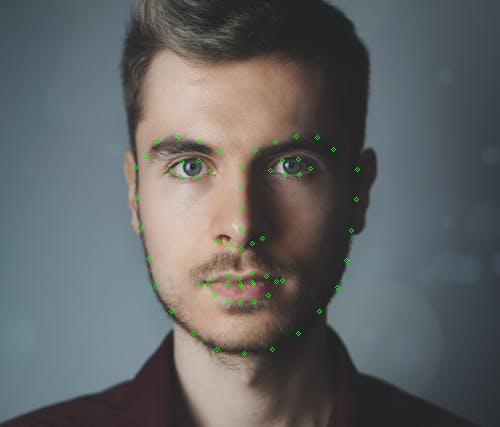

In [0]:
# try and test dlib library
path = "drive/My Drive/CV Proj/2.jpeg"
img = cv2.imread(path)
# cv2_imshow(img)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(
    "drive/My Drive/CV Proj/shape_predictor_68_face_landmarks.dat"
)

dets = detector(gray, 1)
for face in dets:
    shape = predictor(img, face)
    for pt in shape.parts():
        pt_pos = (pt.x, pt.y)
        cv2.circle(img, pt_pos, 2, (0, 255, 0), 1)
    cv2_imshow(img)

In [0]:
predictor_model = "drive/My Drive/CV Proj/shape_predictor_68_face_landmarks.dat"

def get_points(image):
    face_detector = dlib.get_frontal_face_detector()
    face_pose_predictor = dlib.shape_predictor(predictor_model)
    try:
        detected_face = face_detector(image, 1)[0]
    except:
        print('No face detected in image {}'.format(image))
    pose_landmarks = face_pose_predictor(image, detected_face)
    points = []
    for p in pose_landmarks.parts():
        points.append([p.x, p.y])

    x = image.shape[1] - 1
    y = image.shape[0] - 1
    points.append([0, 0])
    points.append([x // 2, 0])
    points.append([x, 0])
    points.append([x, y // 2])
    points.append([x, y])
    points.append([x // 2, y])
    points.append([0, y])
    points.append([0, y // 2])

    return np.array(points)

def get_triangles(points):
    return Delaunay(points).simplices

def affine_transform(input_image, input_triangle, output_triangle, size):
    warp_matrix = cv2.getAffineTransform(
        np.float32(input_triangle), np.float32(output_triangle))
    output_image = cv2.warpAffine(input_image, warp_matrix, (size[0], size[1]), None,
                                  flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
    return output_image


def morph_triangle(img1, img2, img, tri1, tri2, tri, alpha):
    rect1 = cv2.boundingRect(np.float32([tri1]))
    rect2 = cv2.boundingRect(np.float32([tri2]))
    rect = cv2.boundingRect(np.float32([tri]))

    tri_rect1 = []
    tri_rect2 = []
    tri_rect_warped = []

    for i in range(0, 3):
        tri_rect_warped.append(
            ((tri[i][0] - rect[0]), (tri[i][1] - rect[1])))
        tri_rect1.append(
            ((tri1[i][0] - rect1[0]), (tri1[i][1] - rect1[1])))
        tri_rect2.append(
            ((tri2[i][0] - rect2[0]), (tri2[i][1] - rect2[1])))

    img1_rect = img1[rect1[1]:rect1[1] +
                     rect1[3], rect1[0]:rect1[0] + rect1[2]]
    img2_rect = img2[rect2[1]:rect2[1] +
                     rect2[3], rect2[0]:rect2[0] + rect2[2]]

    size = (rect[2], rect[3])
    warped_img1 = affine_transform(
        img1_rect, tri_rect1, tri_rect_warped, size)
    warped_img2 = affine_transform(
        img2_rect, tri_rect2, tri_rect_warped, size)

    img_rect = (1.0 - alpha) * warped_img1 + alpha * warped_img2

    # mask
    mask = np.zeros((rect[3], rect[2], 3), dtype=np.float32)
    cv2.fillConvexPoly(mask, np.int32(tri_rect_warped), (1.0, 1.0, 1.0), 16, 0)

    img[rect[1]:rect[1] + rect[3], rect[0]:rect[0] + rect[2]] = \
        img[rect[1]:rect[1] + rect[3], rect[0]:rect[0] +
            rect[2]] * (1 - mask) + img_rect * mask


def morph_faces(img1, img2, alpha=0.5):
    points1 = get_points(img1)
    points2 = get_points(img2)
    points = (1 - alpha) * np.array(points1) + alpha * np.array(points2)

    img1 = np.float32(img1)
    img2 = np.float32(img2)
    img_morphed = np.zeros(img1.shape, dtype=img1.dtype)

    triangles = get_triangles(points)
    for i in triangles:
        x = i[0]
        y = i[1]
        z = i[2]

        tri1 = [points1[x], points1[y], points1[z]]
        tri2 = [points2[x], points2[y], points2[z]]
        tri = [points[x], points[y], points[z]]
        morph_triangle(img1, img2, img_morphed, tri1, tri2, tri, alpha)

    return np.uint8(img_morphed)


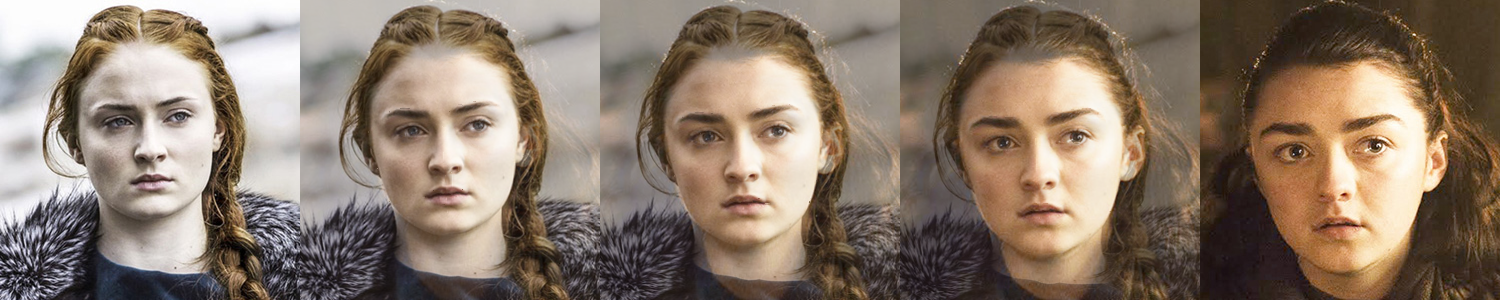

In [0]:
filename1 = "drive/My Drive/CV Proj/1.jpeg"
filename2 = "drive/My Drive/CV Proj/2.jpeg"
filename3 = "drive/My Drive/CV Proj/3.jpg"
filename4 = "drive/My Drive/CV Proj/4.jpg"
filename21 = "drive/My Drive/CV Proj/21.jpg"
filename22 = "drive/My Drive/CV Proj/22.jpg"
filename23 = "drive/My Drive/CV Proj/23.jpg"
filename24 = "drive/My Drive/CV Proj/24.jpg"
image1 = cv2.imread(filename1)
image2 = cv2.imread(filename2)
image3 = cv2.imread(filename3)
image4 = cv2.imread(filename4)
image21 = cv2.imread(filename21)
image22 = cv2.imread(filename22)
image23 = cv2.imread(filename23)
image24 = cv2.imread(filename24)
output = "drive/My Drive/CV Proj/output.png"

num = 1

for i in range(101):
  alpha = 0 if i == 0 else i/100
  path = f"drive/My Drive/CV Proj/seq_{num}_{i}.png"
  img_tmp = morph_faces(image21, image22, alpha)
  cv2.imwrite(path, img_tmp)

num = 2

for i in range(101):
  alpha = 0 if i == 0 else i/100
  path = f"drive/My Drive/CV Proj/seq_{num}_{i}.png"
  img_tmp = morph_faces(image22, image23, alpha)
  cv2.imwrite(path, img_tmp)

num = 3

for i in range(101):
  alpha = 0 if i == 0 else i/100
  path = f"drive/My Drive/CV Proj/seq_{num}_{i}.png"
  img_tmp = morph_faces(image23, image24, alpha)
  cv2.imwrite(path, img_tmp)

num = 4

for i in range(101):
  alpha = 0 if i == 0 else i/100
  path = f"drive/My Drive/CV Proj/seq_{num}_{i}.png"
  img_tmp = morph_faces(image24, image21, alpha)
  cv2.imwrite(path, img_tmp)

img_seq0 = morph_faces(image21, image22, alpha=0)
# img_seq2 = morph_faces(image1, image2, alpha=0.2)
img_seq3 = morph_faces(image21, image22, alpha=0.3)
# img_seq4 = morph_faces(image1, image2, alpha=0.4)
img_seq5 = morph_faces(image21, image22, alpha=0.5)
# img_seq6 = morph_faces(image1, image2, alpha=0.6)
img_seq7 = morph_faces(image21, image22, alpha=0.7)
# img_seq8 = morph_faces(image1, image2, alpha=0.8)
img_seq10 = morph_faces(image21, image22, alpha=1)
img_seq = np.hstack((img_seq0, img_seq3, img_seq5, img_seq7, img_seq10))
cv2_imshow(img_seq)
# cv2_imshow(img_seq0)
# cv2_imshow(img_seq2)
# cv2_imshow(img_seq4)
# cv2_imshow(img_seq6)
# cv2_imshow(img_seq8)
# cv2_imshow(img_seq10)
# cv2.imwrite("drive/My Drive/CV Proj/seq_100.png", img_seq10)
# cv2_imshow(image3)